Thanh Truc Bui

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


<font size="5">Read the protein mass table</font>

In [3]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [6]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [7]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
#enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from esm2 embeddings</font>

In [5]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [6]:
def PCA_for_emb(emb:list,n:int):   #Reducing the embedding vector to n dimensions
    pca = PCA(n_components=n)
    emb_pca = pca.fit_transform(emb)
    return emb_pca


In [7]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb))
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map


enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


In [ ]:
enzymes_split100_map = read_esm2("/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/split100_esm2_3b.h5",enzymes_split100_map)


<font size="5">Find out the most common last amino acid of the enzymes and non-enzymes set</font>

In [ ]:
def most_common_last_aa(seq_map:dict):
    last_aa_list=dict()
    for header in seq_map.keys():
        last=seq_map[header].last_aa
        if not last in last_aa_list:
            last_aa_list[last] = 0
        last_aa_list[last]+=1
    common_aa=[]
    for aa in last_aa_list.keys():
        if not aa=="X":
            if (last_aa_list[aa]/len(seq_map))>0.09:
                common_aa.append(aa)
                print (last_aa_list[aa]/len(seq_map))
    return common_aa

enzymes_common_last_aa=most_common_last_aa(enzymes_map)
print(enzymes_common_last_aa)
non_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)
print(non_enzymes_common_last_aa)


The most common last amino acids are not significant and thus will be ignored

<font size="5">Looking for some kmers<font>

In [8]:
def hamming_distance(Genome1:str, Genome2:str):
    distance=0
    for i in range(len(Genome1)):
        if Genome1[i]!=Genome2[i]:
            distance+=1
    return distance

def neighbors(Pattern: str, d: int):
    if d==0:
        return [Pattern]
    
    if len(Pattern)==1:
        return ['A', 'C', 'G', 'T']
    
    neighborhood=[]
    suffix_neighbors=neighbors(Pattern[1:], d)
    for text in suffix_neighbors:
        if hamming_distance(Pattern[1:], text)<d:
            for x in ['A', 'C', 'G', 'T']:
                neighborhood.append(x+text)
        else:
            neighborhood.append(Pattern[0]+text)
    return neighborhood

def max_map(freq_map):
    max=0
    for key in freq_map.keys():
        if freq_map[key]>max:
            max=freq_map[key]
    return max

def kmer_with_max_d_mismatch(protein_map:dict(), k:int, d: int):
    Patterns=[]
    kmers_map=dict()

    for protein in protein_map.keys():
        Text=protein_map[protein].seq
        for i in range(len(Text)-k+1):
            Pattern=Text[i:i+k]
            neigherborhood=neighbors(Pattern, d)
            for j in range(len(neigherborhood)):    #Every neighbor of a pattern can be a key in the map. Now we find out which key has the highest value
                neighbor=neigherborhood[j]
                if not neighbor in kmers_map.keys():
                    kmers_map[neighbor]=1
                else:
                    kmers_map[neighbor]+=1
    
    m=max_map(kmers_map)
    for key in kmers_map.keys():
        if kmers_map[key]==m:
            Patterns.append(key)
    
    return Patterns


In [10]:
kmer_with_max_d_mismatch(enzymes_map, 20, 1)


['NNNNNNNNNNNNNNNNNNNA', 'NNNNNNNNNNNNNNNNNNNG']

In [11]:
kmer_with_max_d_mismatch(non_enzymes_map, 20, 1)


['NNNNNNNNNNNNNNNNNNNA']

Pick the best n for the PCA

In [8]:
embs_enzymes=[]
embs_non_enzymes=[]

for protein in enzymes_map.keys():
    embs_enzymes.append(enzymes_map[protein].embeddings)
for protein in non_enzymes_map.keys():
    embs_non_enzymes.append(non_enzymes_map[protein].embeddings)



In [9]:

def pick_n_for_pca(embs):
    pca = PCA().fit(embs)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 2561, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks([256,512,700,1024,2048,2560])    
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()


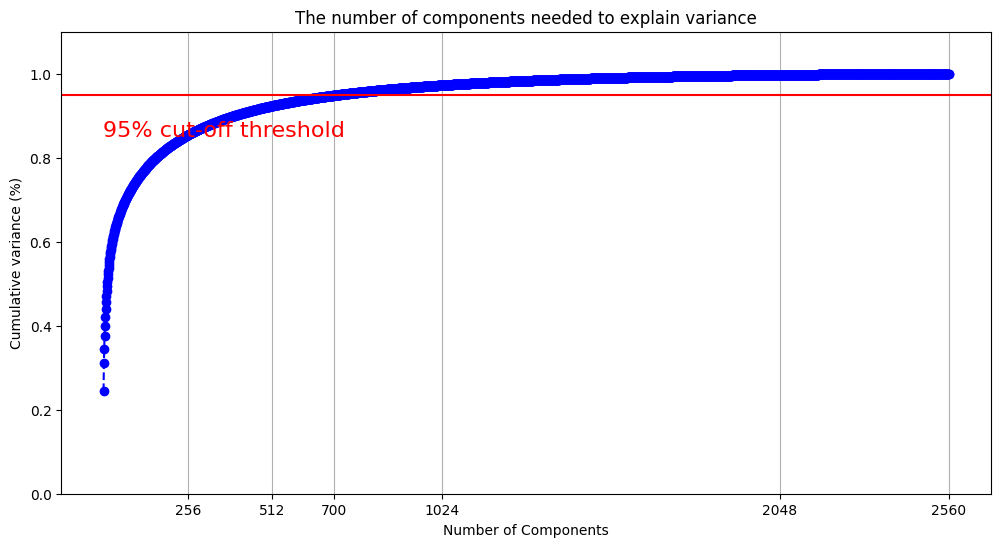

In [10]:

pick_n_for_pca(embs_enzymes)

In [ ]:
pick_n_for_pca(embs_non_enzymes)

Now that with n=700 we get 95% cut off, we choose PCA with 700 dimension

<font size="5">Create a dataframe<font>

In [11]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        
    emb_pca_all=PCA_for_emb(np.array(embs),700).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [12]:

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


       Label       Entry        Mass  \
0          1  A0A024RBG1   20403.292   
1          1  A0A024SMV2   42741.490   
2          1  A0A060S684   63631.543   
3          1  A0A075TXZ3   61430.846   
4          1  A0A077K8G3   45202.778   
...      ...         ...         ...   
48701      0      X2JAU8  117164.590   
48702      0      X5HYT8   46670.171   
48703      0      X5LX76  118226.070   
48704      0      X6R8D5   14504.182   
48705      0      X6R8R1   52161.639   

                                                     Emb  Emb median  \
0      [-0.015143169, 0.035552002, -0.02231326, 0.002...   -0.003883   
1      [0.059097216, -0.034141198, 0.061426997, 0.006...   -0.002613   
2      [-0.016934631, -0.04490467, 0.0054878886, -0.0...   -0.002250   
3      [-0.06815035, -0.034723807, 0.03341713, -0.057...   -0.001353   
4      [-0.03639361, 0.046453245, 0.06140146, -0.0697...   -0.004369   
...                                                  ...         ...   
48701  [-0.0968

In [ ]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_emb_df.csv', index = False)

PCA -> df

In [ ]:
for i in range(700):
    df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
df_with_enzyme_dup


In [ ]:
'''
split100_enzymes_df=making_df(enzymes_split100_map)
split100_enzymes_df=split100_enzymes_df.sort_values(['Entry'],ascending=[True])
split100_enzymes_df.to_csv(r'/home/trucbui/PBLGit/random_forest/dataframe_split100')  
'''

In [ ]:
#split100_enzymes_df

<font size="5">Train the model</font>

In [ ]:
'''
split100_enzymes_df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/dataframe_split100',index_col=[0])
df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/dataframe_split30_and_non_enzymes',index_col=[0])
df=df.drop(df.index[:9204])
df=pd.concat([df,split100_enzymes_df],axis=0)
df=df.reset_index(drop=True)
df
'''

Duplicate the enzymes class to achieve a balanced dataframe

In [ ]:
enzymes_df_dup=enzymes_df.loc[enzymes_df.index.repeat(4)].reset_index(drop=True)
enzymes_df_dup

In [ ]:
df_with_enzyme_dup=pd.concat([enzymes_df_dup,non_enzymes_df,],axis=0)
df_with_enzyme_dup=df_with_enzyme_dup.reset_index(drop=True)
df_with_enzyme_dup

In [77]:
df_with_enzyme_dup.to_csv(r'/home/trucbui/PBLGit/random_forest/split30dup__and_non_enzymes_with_emb_df.csv', index = False)

In [8]:
df_with_enzyme_dup=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/split30dup__and_non_enzymes_with_emb_df.csv')

In [10]:
df_with_enzyme_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,PCA 2,...,PCA 691,PCA 692,PCA 693,PCA 694,PCA 695,PCA 696,PCA 697,PCA 698,PCA 699,PCA 700
0,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.7201108336448669, 0.1448671519756317, 0.30...",-0.720111,0.144867,...,-0.014237,-0.005821,-0.006216,-0.009365,0.029519,0.003641,0.010205,-0.030442,-0.003021,0.033887
1,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.7201108336448669, 0.1448671519756317, 0.30...",-0.720111,0.144867,...,-0.014237,-0.005821,-0.006216,-0.009365,0.029519,0.003641,0.010205,-0.030442,-0.003021,0.033887
2,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.7201108336448669, 0.1448671519756317, 0.30...",-0.720111,0.144867,...,-0.014237,-0.005821,-0.006216,-0.009365,0.029519,0.003641,0.010205,-0.030442,-0.003021,0.033887
3,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.7201108336448669, 0.1448671519756317, 0.30...",-0.720111,0.144867,...,-0.014237,-0.005821,-0.006216,-0.009365,0.029519,0.003641,0.010205,-0.030442,-0.003021,0.033887
4,1,A0A024SMV2,42741.490,[ 0.05909722 -0.0341412 0.061427 ... 0.03...,-0.002613,0.224955,11.381984,"[1.1132580041885376, -0.09059897065162659, -0....",1.113258,-0.090599,...,0.016227,0.046075,-0.012710,0.028700,-0.012934,-0.025600,0.019037,-0.041620,0.036419,0.036128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76313,0,X2JAU8,117164.590,[-0.09689512 -0.09052379 -0.01670158 ... 0.07...,-0.003210,0.218149,11.037591,"[3.928795099258423, 1.0540282726287842, 0.0701...",3.928795,1.054028,...,0.020648,-0.013315,0.012706,0.006887,0.004746,0.021182,-0.018262,0.025106,-0.029632,-0.016835
76314,0,X5HYT8,46670.171,[ 0.00238196 -0.03362084 0.04362515 ... -0.00...,-0.003682,0.267518,13.535640,"[-0.8071576356887817, 0.2815757989883423, 0.49...",-0.807158,0.281576,...,-0.023908,0.001889,0.015918,0.015016,-0.003596,0.013889,0.006753,-0.013292,-0.008591,0.003652
76315,0,X5LX76,118226.070,[-0.00353753 -0.02188075 -0.02843632 ... 0.03...,-0.003806,0.255798,12.942582,"[0.036186333745718, -0.4261864721775055, -0.26...",0.036186,-0.426186,...,-0.009277,0.024921,-0.001686,-0.010260,0.013944,0.005201,0.007544,-0.029421,-0.018353,0.002027
76316,0,X6R8D5,14504.182,[-0.00908377 -0.05840173 0.02271953 ... -0.00...,-0.004650,0.287314,14.537300,"[-2.6940062046051025, 2.3132100105285645, 0.50...",-2.694006,2.313210,...,0.007128,-0.001473,0.034751,-0.009290,0.000835,0.015074,0.003659,0.008645,-0.017182,0.007734


In [37]:
#Define the features and output:
y = df_with_enzyme_dup['Label']
X = df_with_enzyme_dup.drop(['Label','Entry','Emb', 'Emb median','Emb std','Emb PCA'],axis=1)
#X = df_with_enzyme_dup[['Emb std','Mass']]

#Split data into train an test, with test size of 33%%:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)


In [35]:

#Build the model:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=8,n_estimators=100)
rf.fit(X_train, y_train)
y_pred=rf.predict(X)

<font size="5">Evaluate the model</font>

accuracy on training set: 0.908728
accuracy on test set: 0.886162
F1 score: 0.9034374919894389
MCC score: 0.8084540230318509


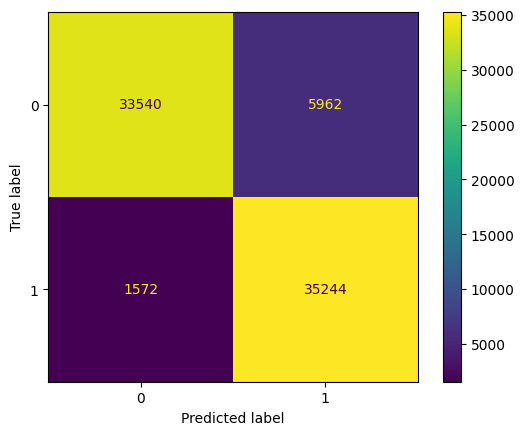

In [36]:
cm=confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
print("accuracy on training set: %f" % rf.score(X_train, y_train))
print("accuracy on test set: %f" % rf.score(X_test, y_test))
f1 = f1_score(y, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y, y_pred)
print('MCC score:', mcc_score)


<font size="5">Make a tree</font>

In [31]:
tree = rf.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file:
graph.write_png('tree_rf.png')

<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.9740765376335004


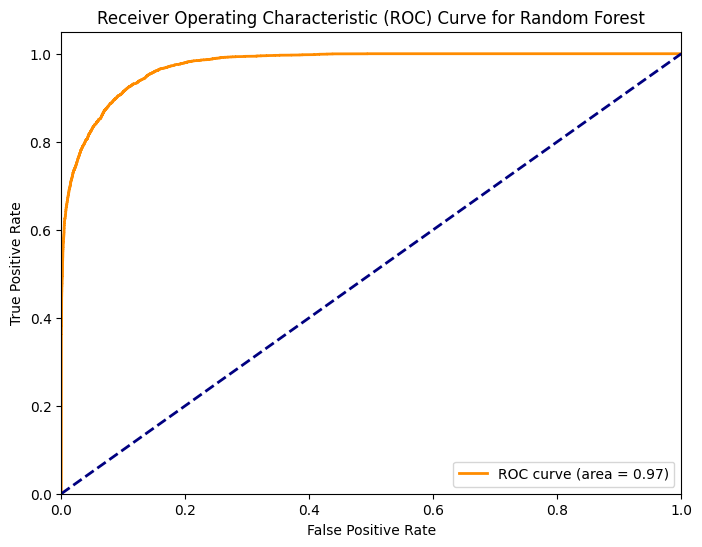

In [30]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()